## Purpose

In this notebook I explored the FastSAM model for segmentation of whole leaves given an input dataset of coffee leaves. The purpose was to introduce a solution whereby the dataset can be augmented by segmenting a single leaf (the leaf in focus at the center) from the image and removing the background. This background-removed dataset will be used for modeling as an experiment to confirm whether segmented datasets will peform well for the downstream disease classification task.

In this notebook, I have contributed the following:

1. Show an example of using FastSAM model for a single dataset and compare with the output from the removebg library.

2. Use the FastSAM library to generate a Segmented coffee leaf dataset.

3. Build a UI using ipywidet library to build an interactive GUI to browse through the dataset, and visualize the segmented outputs from FastSAM and removebg for comparison.

Note: the for 1. the text prompt was used in FastSAM for segmentation.
for 2. and 3. the point prompts were used in FastSAM for segmentation.


## Get the coffee dataset

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%env DATA_DIRECTORY = /content/drive/MyDrive/Task-3-Data Augmentation/data
%env TEST_DATA_DIRECTORY = /content/drive/MyDrive/Task-4-Model(s) Building/data

env: DATA_DIRECTORY=/content/drive/MyDrive/Task-3-Data Augmentation/data
env: TEST_DATA_DIRECTORY=/content/drive/MyDrive/Task-4-Model(s) Building/data


In [ ]:
directory = os.environ.get("DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/content/drive/MyDrive/Task-3-Data Augmentation/data


In [ ]:
from pathlib import Path
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
def checkPathExists(path):
  if not os.path.exists(path):
    print(f"Cannot access path: {path}")
  else:
    print (f"Path {path} accessible")

In [ ]:
checkPathExists(root_dir)

Path /content/drive/MyDrive/Task-3-Data Augmentation/data accessible


In [ ]:
DataPathList = [ path for path in Path(root_dir).iterdir()]

In [ ]:
DataPathList

[PosixPath('/content/drive/MyDrive/Task-3-Data Augmentation/data/002_strategy_just_single_leaves'),
 PosixPath('/content/drive/MyDrive/Task-3-Data Augmentation/data/001_strategy_full_single_and_cropped_leaves')]

In [ ]:
SINGLE_LEAVES_DATA_DIR = Path(root_dir).joinpath('002_strategy_just_single_leaves/train_opencv_resized')

In [ ]:

SingleLeafPathList = [ path for path in Path(SINGLE_LEAVES_DATA_DIR).iterdir()]

In [ ]:
def buildDataFrame(pathlist):
  all_list = []
  for path in pathlist:
    for j, p in enumerate(path.glob(f"*")):
      all_list.append((path, p))

  df = pd.DataFrame(all_list, columns=['Disease', 'Image'])
  return df


In [ ]:
df = buildDataFrame(SingleLeafPathList)

In [ ]:
df.groupby(by='Disease').count()

,Image
Disease,
/content/drive/MyDrive/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train_opencv_resized/Cescospora,200
/content/drive/MyDrive/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train_opencv_resized/Healthy,738
/content/drive/MyDrive/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train_opencv_resized/Miner,1009
/content/drive/MyDrive/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train_opencv_resized/Phoma,826
/content/drive/MyDrive/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train_opencv_resized/Rust,1671


In [ ]:
df.head()

,Disease,Image
0,/content/drive/MyDrive/Task-3-Data Augmentatio...,/content/drive/MyDrive/Task-3-Data Augmentatio...
1,/content/drive/MyDrive/Task-3-Data Augmentatio...,/content/drive/MyDrive/Task-3-Data Augmentatio...
2,/content/drive/MyDrive/Task-3-Data Augmentatio...,/content/drive/MyDrive/Task-3-Data Augmentatio...
3,/content/drive/MyDrive/Task-3-Data Augmentatio...,/content/drive/MyDrive/Task-3-Data Augmentatio...
4,/content/drive/MyDrive/Task-3-Data Augmentatio...,/content/drive/MyDrive/Task-3-Data Augmentatio...


In [ ]:
imagelist = df['Image'].astype('str')

In [ ]:
[(i, o) for i, o in enumerate(imagelist) if 'C12P36E2' in o]

[(4410,
  '/content/drive/MyDrive/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train_opencv_resized/Rust/C12P36E2.jpg')]

## Install FastSAM

In [ ]:
!git clone https://github.com/CASIA-IVA-Lab/FastSAM.git

Cloning into 'FastSAM'...
remote: Enumerating objects: 1171, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 1171 (delta 201), reused 186 (delta 186), pack-reused 929
Receiving objects: 100% (1171/1171), 72.45 MiB | 37.21 MiB/s, done.
Resolving deltas: 100% (456/456), done.


In [ ]:
!wget https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt

--2023-09-23 01:27:30--  https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt
Resolving huggingface.co (huggingface.co)... 18.164.174.23, 18.164.174.17, 18.164.174.55, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.23|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/71/c3/71c3ec5a83f3fc374665cec9240f614262e29088fca1a18732571e13c7084f1b/c0be4e7ddbe4c15333d15a859c676d053c486d0a746a3be6a7a9790d52a9b6d7?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27FastSAM.pt%3B+filename%3D%22FastSAM.pt%22%3B&Expires=1695691650&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5NTY5MTY1MH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy83MS9jMy83MWMzZWM1YTgzZjNmYzM3NDY2NWNlYzkyNDBmNjE0MjYyZTI5MDg4ZmNhMWExODczMjU3MWUxM2M3MDg0ZjFiL2MwYmU0ZTdkZGJlNGMxNTMzM2QxNWE4NTljNjc2ZDA1M2M0ODZkMGE3NDZhM2JlNmE3YTk3OTBkNTJhOWI2ZDc%7EcmVzcG9uc

In [ ]:
!pip install -r FastSAM/requirements.txt
!pip install git+https://github.com/openai/CLIP.git
!pip install rembg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.7/611.7 kB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine

In [ ]:
import matplotlib.pyplot as plt
import cv2
from rembg import remove

## Example usage of FastSAM

C12P36E2 C8P30E1

In [ ]:
image = cv2.imread('/content/drive/MyDrive/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train/Rust/C12P36E2.jpg')
image_0 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
!python FastSAM/Inference.py \
         --model_path FastSAM.pt \
         --img_path '/content/drive/MyDrive/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train/Rust/C12P36E2.jpg' \
         --imgsz 1024 --text_prompt "the longest leaf" \
         --withContours True \
         --device 'cuda'


0: 576x1024 51 objects, 139.0ms
Speed: 10.2ms preprocess, 139.0ms inference, 59.2ms postprocess per image at shape (1, 3, 1024, 1024)
100%|███████████████████████████████████████| 338M/338M [00:09<00:00, 36.2MiB/s]


In [ ]:
def VisualizeSingleImage(image, ax):
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(image)

In [ ]:
def VisualizeSegmentatedOutput(originalImage, segmentedImage):
  fig, ax = plt.subplots(1, 3)
  print(ax.shape)
  VisualizeSingleImage(originalImage, ax[0])
  #VisualizeSingleImage(np.transsegmentedImage, ax[1])
  im_gray = cv2.cvtColor(segmentedImage, cv2.COLOR_BGR2GRAY)
  th, im_th = cv2.threshold(im_gray, 1, 255, cv2.THRESH_BINARY)
  new_image = cv2.bitwise_and(originalImage, originalImage, mask = np.transpose(im_th, (1, 0)))
  VisualizeSingleImage(new_image, ax[1])
  rembgout = remove(originalImage)
  VisualizeSingleImage(rembgout, ax[2])

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 158GB/s]


(3,)


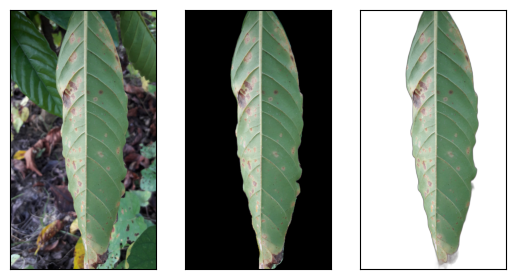

In [ ]:
imagebg = cv2.imread('output/C12P36E2.jpg')
imagebg = cv2.cvtColor(imagebg, cv2.COLOR_BGR2RGB)
imagebg = cv2.flip(imagebg, 0)

output = remove(imagebg)
VisualizeSegmentatedOutput(image_0, output)

## Install the FastSAM package to use as a library within Python Code

In [ ]:
!pip install segment-anything-fast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368606 sha256=65e97952c58aefb4740d12a8180edeab2f1a246b8e8d6e64f6ca4c7d92fe5c5a
  Stored in directory: /root/.cache/pip/wheels/08/77/8e/8d2f862df6bf7fb4e2007062d2cbaeae49862ec7b56d041229
Successfully built openai-clip


Set up the FastSAM model

In [ ]:
from fastsam import FastSAM, FastSAMPrompt
import torch

In [ ]:
model = FastSAM('FastSAM.pt')
DEVICE = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

## Build A FastSAM Segmented Dataset

In [ ]:
def saveSegmentedImage(originalImage, segmentedImage, outputFolder):
  output_path = outputFolder / originalImage.name
  if output_path.is_file():
    return
  image = cv2.imread(str(originalImage))
  image_0 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  seg = cv2.imread(str(segmentedImage))
  if seg is None:
    new_image = remove(image_0)
  else:
    imagebg = cv2.cvtColor(seg, cv2.COLOR_BGR2RGB)
    imagebg = remove(imagebg)
    im_gray = cv2.cvtColor(imagebg, cv2.COLOR_BGR2GRAY)
    th, im_th = cv2.threshold(im_gray, 1, 255, cv2.THRESH_BINARY)
    new_image = cv2.bitwise_and(image_0, image_0, mask = im_th)
  new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
  cv2.imwrite(str(output_path), new_image)

In [ ]:
def segmentImages(inputFolder, outputFolder):
  for c in CLASSNAMES:
    folder_path = Path(inputFolder)/c
    output_path = Path(outputFolder)/c
    output_path.mkdir(parents=True, exist_ok=True)
    print(f"Track {c}")
    for image_path in folder_path.glob('*'):
      if output_path.joinpath(image_path.name).is_file():
        continue
      getSegmentation(image_path, "one center leaf")
      saveSegmentedImage(image_path, Path(f'/content/output/{image_path.name}'), output_path)
      #break
  return

In [ ]:
def getSegmentation(imagePath, textp):
  everything_results = model(
      str(imagePath),
      device=DEVICE,
      retina_masks=True,
      imgsz=1024,
      conf=0.4,
      iou=0.9,
  )
  prompt_process = FastSAMPrompt(str(imagePath), everything_results, device=DEVICE)
  #ann = prompt_process.text_prompt(text=textp)
  ann = prompt_process.everything_prompt()
  prompt_process.plot(annotations=ann, output_path=f'/content/output/all_{imagePath.name}')
  imagept = cv2.imread(f'{imagePath}')
  w, h = int(imagept.shape[1]/2), int(imagept.shape[0]/2)
  ann = prompt_process.point_prompt(points=[[w, h], [0, 0],
                                            [w, 0], [2*w-1, 0],
                                            [2*w-1, h], [2*w-1, 2*h-1],
                                            [w, 2*h-1], [0, 2*h-1], [0, h]], pointlabel=[1, 0, 0, 0, 0, 0, 0, 0, 0])
  prompt_process.plot(annotations=ann, output_path=f'/content/output/{imagePath.name}', withContours=False)

In [ ]:
OUTPUT_FOLDER = Path(root_dir).joinpath('002_strategy_just_single_leaves/train_opencv_resized_FASTSAM_Seg')
OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)
CLASSNAMES = ['Healthy', 'Cescospora', 'Miner', 'Phoma', 'Rust']
#segmentImages(SINGLE_LEAVES_DATA_DIR, OUTPUT_FOLDER)

In [ ]:
testDirectory = os.environ.get("TEST_DATA_DIRECTORY")
SINGLE_LEAVES_DATA_DIR_TEST = Path(testDirectory).joinpath('000_test_and_val_dataset_opencv_resized')
OUTPUT_FOLDER = Path(testDirectory).joinpath('000_test_and_val_dataset_opencv_resized_FASTSAM_Seg')
OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)
segmentImages(SINGLE_LEAVES_DATA_DIR_TEST, OUTPUT_FOLDER)

Track Healthy
Track Cescospora
Track Miner
Track Phoma
Track Rust


## Make a UI for Interactive Segmentation and Visualization

In [ ]:
flist = df.Disease.unique().tolist()
flist.append('A')
dropdown_class = widgets.Dropdown(value= 'A', options = flist, layout={'width': 'max-content'})
dropdown_image = widgets.Dropdown(layout={'width': 'max-content'})
image_widget = widgets.Image(format='png', layout=widgets.Layout(width='400px'))
segsam_widget = widgets.Image(format='png', layout=widgets.Layout(width='400px'))
segsamall_widget = widgets.Image(format='png', layout=widgets.Layout(width='400px'))
segrembg_widget = widgets.Image(format='png', layout=widgets.Layout(width='400px'))
hbox1 = widgets.HBox([image_widget, segsam_widget, segsamall_widget, segrembg_widget])
val = 0


In [ ]:
def imageVis(year):
    #output.clear_output()

    images = df[df['Disease'] == Path(year)]['Image']
    #pathlist = [path for path in Path(year).iterdir()]
    dropdown_image.options = images.tolist()

    file = open(dropdown_image.value, "rb")
    image1 = file.read()
    image_widget.value = image1
    #with output:
    #    display(common_filter)

In [ ]:
def imageNextVis(nimage):
    #output.clear_output()

    file = open(nimage, "rb")
    image1 = file.read()
    imagept = cv2.imread(f'{nimage}')
    image_widget.value = image1
    w, h = int(imagept.shape[1]/2), int(imagept.shape[0]/2)
    getSegmentation(nimage, "one center leaf")

    ofile = Path('output').joinpath(nimage.name)
    file2 = open(ofile, "rb")
    image2 = file2.read()
    segsam_widget.value = image2

    ofile1 = Path('output').joinpath(f"all_{nimage.name}")
    file4 = open(ofile1, "rb")
    image4 = file4.read()
    segsamall_widget.value = image4

    output = remove(imagept)
    cv2.imwrite(f'output/bg_{nimage.name}', output)
    file3 = open(f'output/bg_{nimage.name}', "rb")
    image3 = file3.read()
    segrembg_widget.value = image3

In [ ]:
def dropdown_class_eventhandler(change):
    imageVis(change.new)
def dropdown_image_eventhandler(change):
    imageNextVis(change.new)

In [ ]:
dropdown_class.observe(
dropdown_class_eventhandler, names='value')
dropdown_image.observe(
dropdown_image_eventhandler, names='value')

In [ ]:
btn = widgets.Button(description='Next')
def btn_eventhandler(obj):
  curimage = dropdown_image.value
  dropdown_image.index = dropdown_image.index + 1
  #dropdown_purpose.value = imagelist[val]
  #print('Hello from the {} button'.format(obj.description))

btn.on_click(btn_eventhandler)

In [ ]:
display(dropdown_class)
display(dropdown_image)
display(hbox1)
display(btn)

Dropdown(index=5, layout=Layout(width='max-content'), options=(PosixPath('/content/drive/MyDrive/Task-3-Data A…

Dropdown(layout=Layout(width='max-content'), options=(), value=None)

Button(description='Next', style=ButtonStyle())


image 1/1 /content/drive/MyDrive/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train_opencv_resized/Phoma/cld-kaggle-test-phoma (13).jpg: 1024x1024 4 objects, 167.2ms
Speed: 9.3ms preprocess, 167.2ms inference, 5.3ms postprocess per image at shape (1, 3, 1024, 1024)
